In [1]:
# Google Colab Setup

import sys
import os

%cd /content
!rm -rf Deep-Comedy
!git clone https://github.com/Deep-Poets-Society/Deep-Comedy
%cd Deep-Comedy

sys.path.append(os.getcwd())

!pip install tensorflow
!pip install tensorflow_text

[WinError 2] Impossibile trovare il file specificato: '/content'
C:\Users\pietr\PycharmProjects\Deep-Comedy
C:\Users\pietr\PycharmProjects\Deep-Comedy\Deep-Comedy


"rm" non Š riconosciuto come comando interno o esterno,
 un programma eseguibile o un file batch.
Cloning into 'Deep-Comedy'...
You should consider upgrading via the 'c:\users\pietr\appdata\local\programs\python\python38\python.exe -m pip install --upgrade pip' command.
You should consider upgrading via the 'c:\users\pietr\appdata\local\programs\python\python38\python.exe -m pip install --upgrade pip' command.


In [1]:
from tokenizer import Tokenizer
import tensorflow as tf
import time
import numpy as np
import re
from matplotlib import pyplot as plt
from utils import load_dataset, positional_encoding, loss_function, accuracy_function
from models import Transformer, create_masks
from schedules import CustomSchedule

In [2]:
dataset = load_dataset()
train = dataset['train']
val = dataset['val']

In [3]:
tokenizer = Tokenizer(['[START]', '[END]', '[SYL]', '[C]'], 'res/vocab.txt')

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


In [4]:
BUFFER_SIZE = 20000
BATCH_SIZE = 64

In [5]:
def tokenize_pairs(X, y):
    X = tokenizer.tokenize(X)
    # Convert from ragged to dense, padding with zeros.
    X = X.to_tensor()

    y = tokenizer.tokenize(y)
    # Convert from ragged to dense, padding with zeros.
    y = y.to_tensor()

    return X, y


def make_batches(ds):
    return (ds
            .cache()
            .shuffle(BUFFER_SIZE)
            .batch(BATCH_SIZE)
            .map(tokenize_pairs, num_parallel_calls=tf.data.AUTOTUNE)
            .prefetch(tf.data.AUTOTUNE)
            )

In [6]:
train_batches = make_batches(train)
val_batches = make_batches(val)

TypeError: in user code:


    TypeError: tf__tokenize_pairs() takes 1 positional argument but 2 were given


(1, 2048, 512)


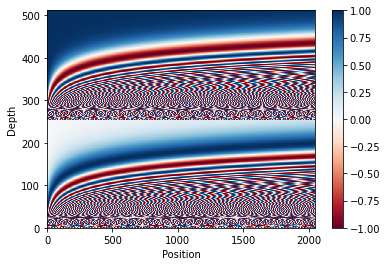

In [7]:
n, d = 2048, 512
pos_encoding = positional_encoding(n, d)
print(pos_encoding.shape)
pos_encoding = pos_encoding[0]
# Juggle the dimensions for the plot
pos_encoding = tf.reshape(pos_encoding, (n, d//2, 2))
pos_encoding = tf.transpose(pos_encoding, (2, 1, 0))
pos_encoding = tf.reshape(pos_encoding, (d, n))

plt.pcolormesh(pos_encoding, cmap='RdBu')
plt.ylabel('Depth')
plt.xlabel('Position')
plt.colorbar()
plt.show()

Set hyperparameters

In [8]:
num_layers = 4
d_model = 128
dff = 512
num_heads = 8
dropout_rate = 0.1

Set Adam optimizer

In [9]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)

Loss and metrics

In [10]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.Mean(name='train_accuracy')

Training and checkpoint

In [11]:
transformer = Transformer(
    num_layers=num_layers,
    d_model=d_model,
    num_heads=num_heads,
    dff=dff,
    input_vocab_size=tokenizer.get_vocab_size().numpy(),
    target_vocab_size=tokenizer.get_vocab_size().numpy(),
    pe_input=1000,
    pe_target=1000,
    rate=dropout_rate)

In [12]:
checkpoint_path = "./checkpoints/train"

ckpt = tf.train.Checkpoint(transformer=transformer,
                           optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print('Latest checkpoint restored!!')

In [13]:
EPOCHS = 20

In [14]:
# The @tf.function trace-compiles train_step into a TF graph for faster
# execution. The function specializes to the precise shape of the argument
# tensors. To avoid re-tracing due to the variable sequence lengths or variable
# batch sizes (the last batch is smaller), use input_signature to specify
# more generic shapes.

train_step_signature = [
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
]


@tf.function(input_signature=train_step_signature)
def train_step(inp, tar):
  tar_inp = tar[:, :-1]
  tar_real = tar[:, 1:]

  with tf.GradientTape() as tape:
    predictions, _ = transformer([inp, tar_inp],
                                 training = True)
    loss = loss_function(tar_real, predictions)

  gradients = tape.gradient(loss, transformer.trainable_variables)
  optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))

  train_loss(loss)
  train_accuracy(accuracy_function(tar_real, predictions))

In [15]:
for epoch in range(EPOCHS):
  start = time.time()

  train_loss.reset_states()
  train_accuracy.reset_states()

  # inp -> X, tar -> y
  for (batch, entry) in enumerate(train_batches):
    inp = entry[0]
    tar = entry[1]
    train_step(inp, tar)

    if batch % 50 == 0:
      print(f'Epoch {epoch + 1} Batch {batch} Loss {train_loss.result():.4f} Accuracy {train_accuracy.result():.4f}')

  if (epoch + 1) % 5 == 0:
    ckpt_save_path = ckpt_manager.save()
    print(f'Saving checkpoint for epoch {epoch+1} at {ckpt_save_path}')

  print(f'Epoch {epoch + 1} Loss {train_loss.result():.4f} Accuracy {train_accuracy.result():.4f}')

  print(f'Time taken for 1 epoch: {time.time() - start:.2f} secs\n')

tf.Tensor(
[[  0 109 195 ...   0   0   0]
 [  0  22  45 ...   0   0   0]
 [  0  11 118 ...   0   0   0]
 ...
 [  0  71 195 ...   0   0   0]
 [  0  20 114 ...   0   0   0]
 [  0 127 195 ...   0   0   0]], shape=(13806, 69), dtype=int64)


InvalidArgumentError:  indices[6472,3] = 195 is not in [0, 195)
	 [[node transformer/encoder/embedding/embedding_lookup (defined at C:\Users\pietr\PycharmProjects\Deep-Comedy\layers.py:137) ]] [Op:__inference_train_step_21135]

Errors may have originated from an input operation.
Input Source operations connected to node transformer/encoder/embedding/embedding_lookup:
 transformer/encoder/embedding/embedding_lookup/13892 (defined at c:\users\pietr\appdata\local\programs\python\python38\lib\contextlib.py:113)	
 inp (defined at <ipython-input-15-b62f956d4139>:12)

Function call stack:
train_step


## Evaluate

In [ ]:
def evaluate(line, max_length=100):
  line = tf.convert_to_tensor([line])
  line = tokenizer.tokenize(line).to_tensor()

  encoder_input = line

  start, end = tokenizer.tokenize([''])[0]
  output = tf.convert_to_tensor([start])
  output = tf.expand_dims(output, 0)

  for i in range(max_length):
    enc_padding_mask, combined_mask, dec_padding_mask = create_masks(
        encoder_input, output)

    # predictions.shape == (batch_size, seq_len, vocab_size)
    predictions, attention_weights = transformer.call((encoder_input, output),
                                                 False)

    # select the last word from the seq_len dimension
    predictions = predictions[:, -1:, :]  # (batch_size, 1, vocab_size)

    predicted_id = tf.argmax(predictions, axis=-1)

    # concatentate the predicted_id to the output which is given to the decoder
    # as its input.
    output = tf.concat([output, predicted_id], axis=-1)

    # return the result if the predicted_id is equal to the end token
    if predicted_id == end:
      break

  # output.shape (1, tokens)
  text = tokenizer.detokenize(output)[0]  # shape: ()

  tokens = tokenizer.lookup(output)[0]

  return text, tokens, attention_weights

In [ ]:
test = dataset['test']
for x, y in test.batch(1):
  x = x.numpy()[0].decode('utf-8')
  y = y.numpy()[0].decode('utf-8')
  y = re.sub('S', '|', y)
  y = re.sub('C', '$', y)
  predicted, tokens, _ = evaluate(x)
  tokens = tokens.numpy()
  predicted = predicted.numpy().decode('utf-8')
  print(f'Original:\t{x}', end = '')
  print(f'Predicted:\t{predicted}')
  print(f'Tokens:\t{tokens}')
  print(f'True:\t\t{y}\n')
